### В данном исследовании проводится исследование процессов, происходящих в полиэтиленовом поршне при различных параметрах

![](nu.jpg)

In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import InterpXY,Tube
from math import *
import numpy as np
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

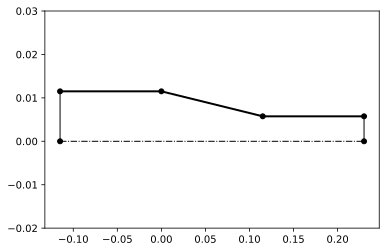

In [8]:
def get_tube(**kw):
    D_1 = kw.get('D_1', 23) * 1e-3 # D_1, mm
    D2_D1 = kw.get('D2_D1', 0.5)
    D_2 = D_1 * D2_D1
    L_D1 = kw.get('L_D1', 5)
    L = D_1 * L_D1
    tube_dict = {
        'tube_points': [[-L,D_1],[0, D_1],[L,D_2],[2*L, D_2]]
    }
    tube = Tube.get_standart(tube_dict)
    return tube

tube = get_tube()
ax, fig = plt.subplots()
tube.plot(ax, fig)
fig.set_ylim(-0.02, 0.03)
# fig.set_xlim(-6*d,d)
plt.show()

In [ ]:
def get_pl(tube, **kw):
    pist_omega = kw.get('pist_omega', 200)/1000
    pist_layer_dict = {
        'type': 'pist',
        'omega': pist_omega,  # кг
        'p_0': kw.get('P_2', 1)*1e5, # начальное давление в полиэтилене
        'u_0': 0,     #начальная скорость
        'ElPistEOS_kwargs': dict(
            k=1.63098, 
            c_0=2308, 
            ro_0=919.03, 
            sigma_star=25.2, 
            k_0=0.054, 
            b_1=0.027, 
            b_2=0.00675, 
            tau_0=1.36, 
            mu=0.001, 
            tau_s=1,                 
            zeroP=False, 
            zeroE=True)
    }
    calc_settings_pist = {
        'cell_dx': 0.001,
    #     'n_cells': 600,
        'n_cells_min': 13,
        'n_cells_max': 100,
        'GasFluxCalculator_kwargs': {'flux_type':1},
        'GridStrecher_kwargs': {}
    }
    pist_lr = ElPistLayer.get_standart(tube, 0, pist_layer_dict, calc_settings_pist) 